In [1]:
import numpy as np
from numpy.random import uniform as u

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [5]:
import findspark
findspark.init()

In [6]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('spark-basic').setMaster('local')
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))

from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp, concat_ws, col, hour, when, lit, avg
import matplotlib.pyplot as plt
import time
import datetime

spark = SparkSession(sc)

In [7]:
!ls ../content

gdrive	sample_data  spark-3.2.0-bin-hadoop3.2	spark-3.2.0-bin-hadoop3.2.tgz


In [8]:
## getting data schema
df = spark.read.csv("/content/gdrive/My Drive/nyc_taxi.csv", header =True, inferSchema=True)
df.printSchema()

root
 |-- pickup_date: string (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- dropoff_date: string (nullable = true)
 |-- dropoff_time: string (nullable = true)
 |-- distance: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- fare: double (nullable = true)



In [9]:
## check data records to get insights
df.show()

+-----------+-----------+------------+------------+--------+----+-----+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|
+-----------+-----------+------------+------------+--------+----+-----+
| 01-01-2017|      00:00|  01-01-2017|       00:00|    0.02| 0.0| 52.8|
| 01-01-2017|      00:00|  01-01-2017|       00:03|     0.5| 0.0|  5.3|
| 01-01-2017|      00:00|  01-01-2017|       00:39|    7.75|4.66|27.96|
| 01-01-2017|      00:00|  01-01-2017|       00:06|     0.8|1.45| 8.75|
| 01-01-2017|      00:00|  01-01-2017|       00:08|     0.9| 0.0|  8.3|
| 01-01-2017|      00:00|  01-01-2017|       00:05|    1.76| 0.0|  8.3|
| 01-01-2017|      00:00|  01-01-2017|       00:15|    8.47|7.71|38.55|
| 01-01-2017|      00:00|  01-01-2017|       00:11|     2.4| 0.0| 11.8|
| 01-01-2017|      00:00|  01-01-2017|       00:23|    12.6|10.0| 70.3|
| 01-01-2017|      00:00|  01-01-2017|       00:08|     0.9|2.05|10.35|
| 01-01-2017|      00:00|  01-01-2017|       00:09|    2.43| 2.7

In [10]:
## remove entries from data, which have 0 and 0.00 values in distance column
filtered_df = df.filter((df.distance != 0) & (df.distance != 0.00))
filtered_df.show()

+-----------+-----------+------------+------------+--------+----+-----+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|
+-----------+-----------+------------+------------+--------+----+-----+
| 01-01-2017|      00:00|  01-01-2017|       00:00|    0.02| 0.0| 52.8|
| 01-01-2017|      00:00|  01-01-2017|       00:03|     0.5| 0.0|  5.3|
| 01-01-2017|      00:00|  01-01-2017|       00:39|    7.75|4.66|27.96|
| 01-01-2017|      00:00|  01-01-2017|       00:06|     0.8|1.45| 8.75|
| 01-01-2017|      00:00|  01-01-2017|       00:08|     0.9| 0.0|  8.3|
| 01-01-2017|      00:00|  01-01-2017|       00:05|    1.76| 0.0|  8.3|
| 01-01-2017|      00:00|  01-01-2017|       00:15|    8.47|7.71|38.55|
| 01-01-2017|      00:00|  01-01-2017|       00:11|     2.4| 0.0| 11.8|
| 01-01-2017|      00:00|  01-01-2017|       00:23|    12.6|10.0| 70.3|
| 01-01-2017|      00:00|  01-01-2017|       00:08|     0.9|2.05|10.35|
| 01-01-2017|      00:00|  01-01-2017|       00:09|    2.43| 2.7

In [11]:
##Using Spark MLlib build a model to predict taxi fare from trip distance (Model: M1)
df_M1 = filtered_df.select("distance", "fare")
df_M1.show(5)

+--------+-----+
|distance| fare|
+--------+-----+
|    0.02| 52.8|
|     0.5|  5.3|
|    7.75|27.96|
|     0.8| 8.75|
|     0.9|  8.3|
+--------+-----+
only showing top 5 rows



In [12]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["distance"], outputCol="features")
model1_df = assembler.transform(df_M1).select("features", "fare")

In [13]:
## spliting training and testing data
from pyspark.ml.regression import LinearRegression

splits = model1_df.randomSplit([0.7, 0.3])
M1train_df = splits[0]
M1test_df = splits[1]

In [14]:
lr_M1 = LinearRegression(featuresCol="features", labelCol="fare")
modelM1 = lr_M1.fit(M1train_df)

In [15]:
prediction_m1 = modelM1.transform(M1test_df)
prediction_m1.show(10)

+--------+----+----------------+
|features|fare|      prediction|
+--------+----+----------------+
|  [0.01]|-3.8|5.52316054107736|
|  [0.01]|-3.8|5.52316054107736|
|  [0.01]|-3.3|5.52316054107736|
|  [0.01]| 3.3|5.52316054107736|
|  [0.01]| 3.3|5.52316054107736|
|  [0.01]| 3.3|5.52316054107736|
|  [0.01]| 3.3|5.52316054107736|
|  [0.01]| 3.3|5.52316054107736|
|  [0.01]| 3.3|5.52316054107736|
|  [0.01]| 3.3|5.52316054107736|
+--------+----+----------------+
only showing top 10 rows



In [16]:
filtered_df.show(10)

+-----------+-----------+------------+------------+--------+----+-----+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|
+-----------+-----------+------------+------------+--------+----+-----+
| 01-01-2017|      00:00|  01-01-2017|       00:00|    0.02| 0.0| 52.8|
| 01-01-2017|      00:00|  01-01-2017|       00:03|     0.5| 0.0|  5.3|
| 01-01-2017|      00:00|  01-01-2017|       00:39|    7.75|4.66|27.96|
| 01-01-2017|      00:00|  01-01-2017|       00:06|     0.8|1.45| 8.75|
| 01-01-2017|      00:00|  01-01-2017|       00:08|     0.9| 0.0|  8.3|
| 01-01-2017|      00:00|  01-01-2017|       00:05|    1.76| 0.0|  8.3|
| 01-01-2017|      00:00|  01-01-2017|       00:15|    8.47|7.71|38.55|
| 01-01-2017|      00:00|  01-01-2017|       00:11|     2.4| 0.0| 11.8|
| 01-01-2017|      00:00|  01-01-2017|       00:23|    12.6|10.0| 70.3|
| 01-01-2017|      00:00|  01-01-2017|       00:08|     0.9|2.05|10.35|
+-----------+-----------+------------+------------+--------+----

In [17]:
##Using Spark MLlib build a model to predict taxi fare from trip distance and trip duration in minutes (Model: M2). M2 will have two features
##include trip duration in minutes in the filtered data
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.appName("TaxiFarePrediction") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

M2_df = spark.read.csv("/content/gdrive/My Drive/nyc_taxi.csv", header=True, inferSchema=True)
M2_df = M2_df.filter((M2_df.distance != 0) & (M2_df.distance != 0.00))
M2_df = M2_df.withColumn("trip_duration(minutes)", (unix_timestamp("dropoff_time", "HH:mm") - unix_timestamp("pickup_time", "HH:mm")) / 60)
M2_df = M2_df.select("distance", "trip_duration(minutes)", "fare")

feature_columns = ["distance", "trip_duration(minutes)"]
assembler2 = VectorAssembler(inputCols=feature_columns, outputCol="features")
M2_df = assembler2.transform(M2_df)

In [18]:
m2train_data, m2test_data = M2_df.randomSplit([0.7, 0.3], seed=123)

lr = LinearRegression(featuresCol="features", labelCol="fare")
m2 = lr.fit(m2train_data)

predictions = m2.transform(m2test_data)

In [19]:
###What is the fare of a 20 mile long trip using M1
from pyspark.sql import SparkSession
from pyspark.sql import Row
spark = SparkSession.builder.appName("fareprediction").getOrCreate()

data_to_predict = [Row(distance=20.0)]
df_to_predict = spark.createDataFrame(data_to_predict)

df_to_predict = assembler.transform(df_to_predict)

predictions = modelM1.transform(df_to_predict)

predicted_fare = predictions.select("prediction").collect()[0][0]

print("For 20 miles predicted fare by model 1:", predicted_fare)

For 20 miles predicted fare by model 1: 71.71175112751916


In [20]:
##What is the fare of a 14 mile trip that took 75 minutes using M2
# Predict taxi fare for a 14-mile, 75-minute trip
data_input = spark.createDataFrame([(14.0, 75.0)], ["distance", "trip_duration(minutes)"])
data_input = assembler2.transform(data_input)
predictions = m2.transform(data_input)
predicted_fare = predictions.select("prediction").first()[0]

print(f"Predicted Fare for a 14-mile, 75-minute trip using M2: {predicted_fare:.2f}")

Predicted Fare for a 14-mile, 75-minute trip using M2: 51.83


In [21]:
### Which fare is higher 10 mile trip taking 40 min or 13 mile trip taking 25 min? Use M2 to answer this question
input_data2 = spark.createDataFrame([(10.0, 40.0), (13.0, 25.0)], ["distance", "trip_duration"])

feature_columns = ["distance", "trip_duration"]
assembler3 = VectorAssembler(inputCols=feature_columns, outputCol="features")
input_data2 = assembler3.transform(input_data2)

predictions = m2.transform(input_data2)

predicted_fares = predictions.select("distance", "trip_duration", "prediction")
predicted_fares.show()

higher_fare = predicted_fares.orderBy("prediction", ascending=False).first()

print(f"The fare for the {higher_fare.distance}-mile trip taking {higher_fare.trip_duration} minutes is higher and fare is: ${higher_fare.prediction:.2f}")



+--------+-------------+------------------+
|distance|trip_duration|        prediction|
+--------+-------------+------------------+
|    10.0|         40.0| 38.58225717004842|
|    13.0|         25.0|48.479274258733284|
+--------+-------------+------------------+

The fare for the 13.0-mile trip taking 25.0 minutes is higher and fare is: $48.48


In [22]:
# Using Spark operations (transformation and actions) compute the average tip amount
data = spark.read.csv("/content/gdrive/My Drive/nyc_taxi.csv", header=True, inferSchema=True)

average_tip = data.agg({"tip": "avg"}).collect()[0][0]

print(f"Average Tip: ${average_tip:.2f}")

Average Tip: $1.70


In [23]:
##During which hour the city experiences the most number of trips? E.g. 10am-11am or 4pm-5pm
from pyspark.sql.functions import hour

data = data.withColumn("pickup_hour", hour("pickup_time"))
trip_per_hour = data.groupBy("pickup_hour").count()
max_trip_per_hour = trip_per_hour.orderBy(trip_per_hour["count"].desc()).first()

print(f"hour the city experiences the most number of trips is {max_trip_per_hour['pickup_hour']} o'clock with {max_trip_per_hour['count']} trips.")


hour the city experiences the most number of trips is 17 o'clock with 73567 trips.


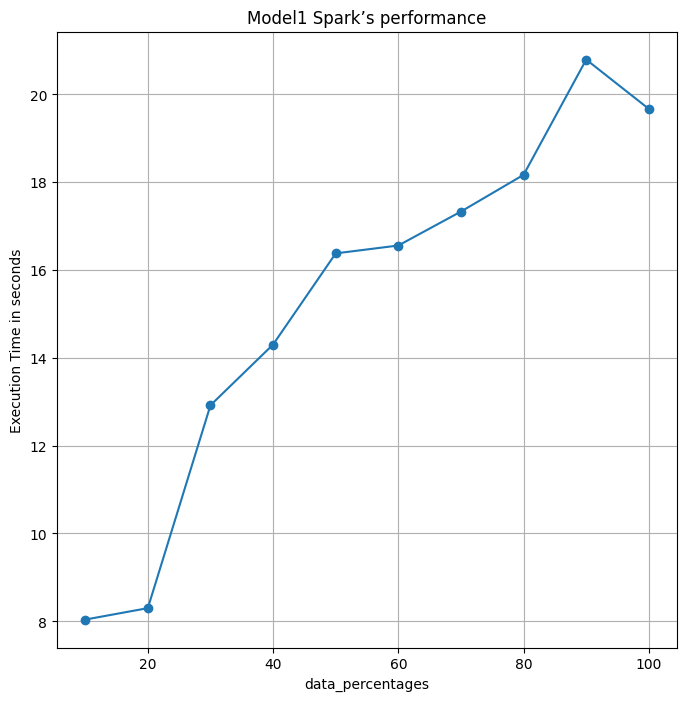

In [24]:
##Compare Spark’s performance of model 1
##Divide the data into 10 parts: 10%, 20%, …, 100%
##Plot the time taken by each method and save in PNG format (or just display the plot if you are using jupyter notebook or Google Colab)
from pyspark.sql.functions import rand
path = "/content/gdrive/My Drive/nyc_taxi.csv"
df = spark.read.csv(path, header=True, inferSchema=True)
filter_df = df.filter((df.distance != 0) & (df.distance != 0.00))

data_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

model_execution_times = []
for percentage in data_percentages:
    num_rows = int(filter_df.count() * percentage / 100)
    subset_data = filter_df.orderBy(rand()).limit(num_rows)
    assembler = VectorAssembler(inputCols=["distance"], outputCol="features")
    m1_df = assembler.transform(subset_data).select("features", "fare")
    train_data1, test_data1 = m1_df.randomSplit([0.7, 0.3])
    lr_Model1 = LinearRegression(featuresCol="features", labelCol="fare")
    start_time = time.time()
    M1 = lr_Model1.fit(train_data1)
    prediction_m1 = M1.transform(test_data1)
    end_time = time.time()

    execution_time = end_time - start_time
    model_execution_times.append(execution_time)

plt.figure(figsize=(8, 8))
plt.plot(data_percentages, model_execution_times, marker='o')
plt.xlabel("data_percentages")
plt.ylabel("Execution Time in seconds")
plt.title("Model1 Spark’s performance")
plt.grid(True)
plt.show()

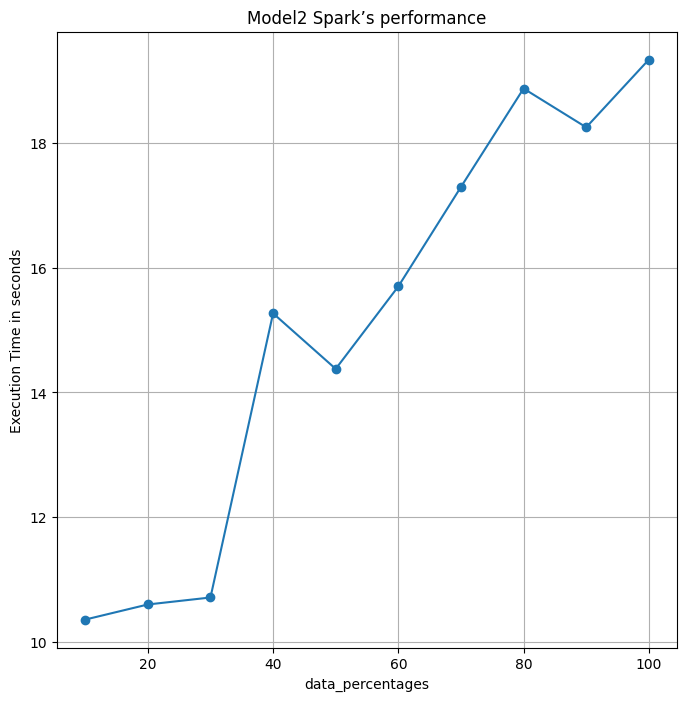

In [25]:
##Compare Spark’s performance of model 2
Model2_df = filter_df.withColumn("trip_duration(minutes)", (unix_timestamp("dropoff_time", "HH:mm") - unix_timestamp("pickup_time", "HH:mm")) / 60)
Model2_df = Model2_df.select("distance", "trip_duration(minutes)", "fare")

model2_execution_times = []
for percentage in data_percentages:
    num_rows = int(Model2_df.count() * percentage / 100)
    subset_data2 = Model2_df.orderBy(rand()).limit(num_rows)
    feature2_columns = ["distance", "trip_duration(minutes)"]
    assembler5 = VectorAssembler(inputCols=feature2_columns, outputCol="features")
    model2_df = assembler.transform(subset_data2).select("features", "fare")
    train_data2, test_data2 = model2_df.randomSplit([0.7, 0.3])
    lr_Model2 = LinearRegression(featuresCol="features", labelCol="fare")

    start_time1 = time.time()
    M2 = lr_Model2.fit(train_data2)
    prediction_m2 = M2.transform(test_data2)
    end_time1 = time.time()

    execution_time1 = end_time1 - start_time1
    model2_execution_times.append(execution_time1)

plt.figure(figsize=(8, 8))
plt.plot(data_percentages, model2_execution_times, marker='o')
plt.xlabel("data_percentages")
plt.ylabel("Execution Time in seconds")
plt.title("Model2 Spark’s performance")
plt.grid(True)
plt.show()
